In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm

resultsPath = Path("../results/MPI_7.csv")


In [9]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["computeUnits"] = dataFrame["computeUnits"].astype(int)
dataFrame["avgWallSeconds"] = dataFrame["avgWallSeconds"].astype(float)
dataFrame["avgCommSeconds"] = dataFrame["avgCommSeconds"].astype(float)
dataFrame["avgComputeSeconds"] = dataFrame["avgComputeSeconds"].astype(float)
dataFrame.head(6)

print("Rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Processes:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)

Rows: 840
Modes: ['blocking' 'nonblocking' 'comm_only' 'compute_only']
Message sizes: [1024, 16384, 65536, 262144, 1048576]
Processes: [1, 2, 4, 6, 8, 16, 32]


,testType,messageSizeBytes,numProcesses,mode,numIterations,computeUnits,avgWallSeconds,avgCommSeconds,avgComputeSeconds,runIndex,mpiEnv
0,MPI_7,1024,1,blocking,50,0,0.000012,0.000003,0.000003,2,SLURM_NTASKS=1;JOBID=26875
1,MPI_7,1024,1,blocking,50,0,0.000011,0.000003,0.000003,1,SLURM_NTASKS=1;JOBID=26874
2,MPI_7,1024,1,blocking,50,0,0.000011,0.000003,0.000003,3,SLURM_NTASKS=1;JOBID=26876
3,MPI_7,1024,1,nonblocking,50,0,0.000007,0.000000,0.000003,1,SLURM_NTASKS=1;JOBID=26877
4,MPI_7,1024,1,nonblocking,50,0,0.000007,0.000000,0.000003,2,SLURM_NTASKS=1;JOBID=26878
5,MPI_7,1024,1,nonblocking,50,0,0.000008,0.000000,0.000003,3,SLURM_NTASKS=1;JOBID=26879
6,MPI_7,1024,1,comm_only,50,0,0.000007,0.000003,0.000000,1,SLURM_NTASKS=1;JOBID=26880
7,MPI_7,1024,1,comm_only,50,0,0.000007,0.000003,0.000000,2,SLURM_NTASKS=1;JOBID=26881


In [10]:
groupedDf  = dataFrame.groupby(["mode","messageSizeBytes","numProcesses","computeUnits"], as_index=False).agg(
    medianWall=("avgWallSeconds","median"),
    medianComm=("avgCommSeconds","median"),
    medianCompute=("avgComputeSeconds","median"),
    count=("avgWallSeconds","count"),
    stdWall=("avgWallSeconds","std")
)
groupedDf ["stdWall"] = groupedDf ["stdWall"].fillna(0.0)
groupedDf.sort_values(["mode","messageSizeBytes","numProcesses","computeUnits"], inplace=True)
groupedDf .head(12)


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall
0,blocking,1024,1,0,0.000011,0.000003,0.000003,3,5.773503e-07
1,blocking,1024,1,200,0.518781,0.000002,0.518772,3,4.933128e-03
2,blocking,1024,2,0,0.000209,0.000199,0.000003,3,4.148895e-05
3,blocking,1024,2,200,0.516568,0.001839,0.514901,3,2.942454e-04
4,blocking,1024,4,0,0.000249,0.000239,0.000003,3,5.623401e-04
5,blocking,1024,4,200,0.531008,0.016582,0.518340,3,9.249321e-03
6,blocking,1024,6,0,0.000477,0.000467,0.000002,3,1.408971e-04
7,blocking,1024,6,200,0.601620,0.046704,0.544917,3,5.351830e-02
8,blocking,1024,8,0,0.001605,0.001595,0.000003,3,3.369674e-04
9,blocking,1024,8,200,0.644951,0.091655,0.553287,3,7.562380e-02


In [11]:
computeOnlyDf = groupedDf[(groupedDf["mode"] == "compute_only") & (groupedDf["computeUnits"] > 0)].copy()
computeOnlyDf["perUnitCompute"] = computeOnlyDf["medianCompute"] / computeOnlyDf["computeUnits"]

globalPerUnit = computeOnlyDf["perUnitCompute"].median() if not computeOnlyDf.empty else np.nan
print("Global per-unit compute time (median from compute_only):", globalPerUnit)
display(computeOnlyDf.head())


Global per-unit compute time (median from compute_only): 0.002668825


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute
141,compute_only,1024,1,200,0.529590,0.0,0.529585,3,0.010277,0.002648
143,compute_only,1024,2,200,0.522924,0.0,0.522919,3,0.024491,0.002615
145,compute_only,1024,4,200,0.515161,0.0,0.515155,3,0.003575,0.002576
147,compute_only,1024,6,200,0.530972,0.0,0.530966,3,0.042684,0.002655
149,compute_only,1024,8,200,0.575804,0.0,0.575798,3,0.065207,0.002879


In [12]:
nbDf = groupedDf[groupedDf["mode"] == "nonblocking"].copy()

def lookupPerUnit(row):
    same = computeOnlyDf[
        (computeOnlyDf["messageSizeBytes"] == row["messageSizeBytes"]) &
        (computeOnlyDf["numProcesses"] == row["numProcesses"])
    ]
    if not same.empty:
        return same["perUnitCompute"].median()
    return globalPerUnit

nbDf["perUnitCompute"] = nbDf.apply(lookupPerUnit, axis=1)

def calcUnitsNeeded(row):
    perUnit = row["perUnitCompute"]
    comm = row["medianComm"]
    if np.isnan(perUnit) or perUnit <= 0 or np.isnan(comm):
        return np.nan
    return int(np.ceil(comm / perUnit))

nbDf["unitsNeeded"] = nbDf.apply(calcUnitsNeeded, axis=1)

display(nbDf[["messageSizeBytes","numProcesses","computeUnits","medianComm","perUnitCompute","unitsNeeded"]].head(20))


,messageSizeBytes,numProcesses,computeUnits,medianComm,perUnitCompute,unitsNeeded
210,1024,1,0,0.000000,0.002648,0
211,1024,1,200,0.000000,0.002648,0
212,1024,2,0,0.000054,0.002615,1
213,1024,2,200,0.000077,0.002615,1
214,1024,4,0,0.000099,0.002576,1
215,1024,4,200,0.000142,0.002576,1
216,1024,6,0,0.000405,0.002655,1
217,1024,6,200,0.001514,0.002655,1
218,1024,8,0,0.001469,0.002879,1
219,1024,8,200,0.060646,0.002879,22


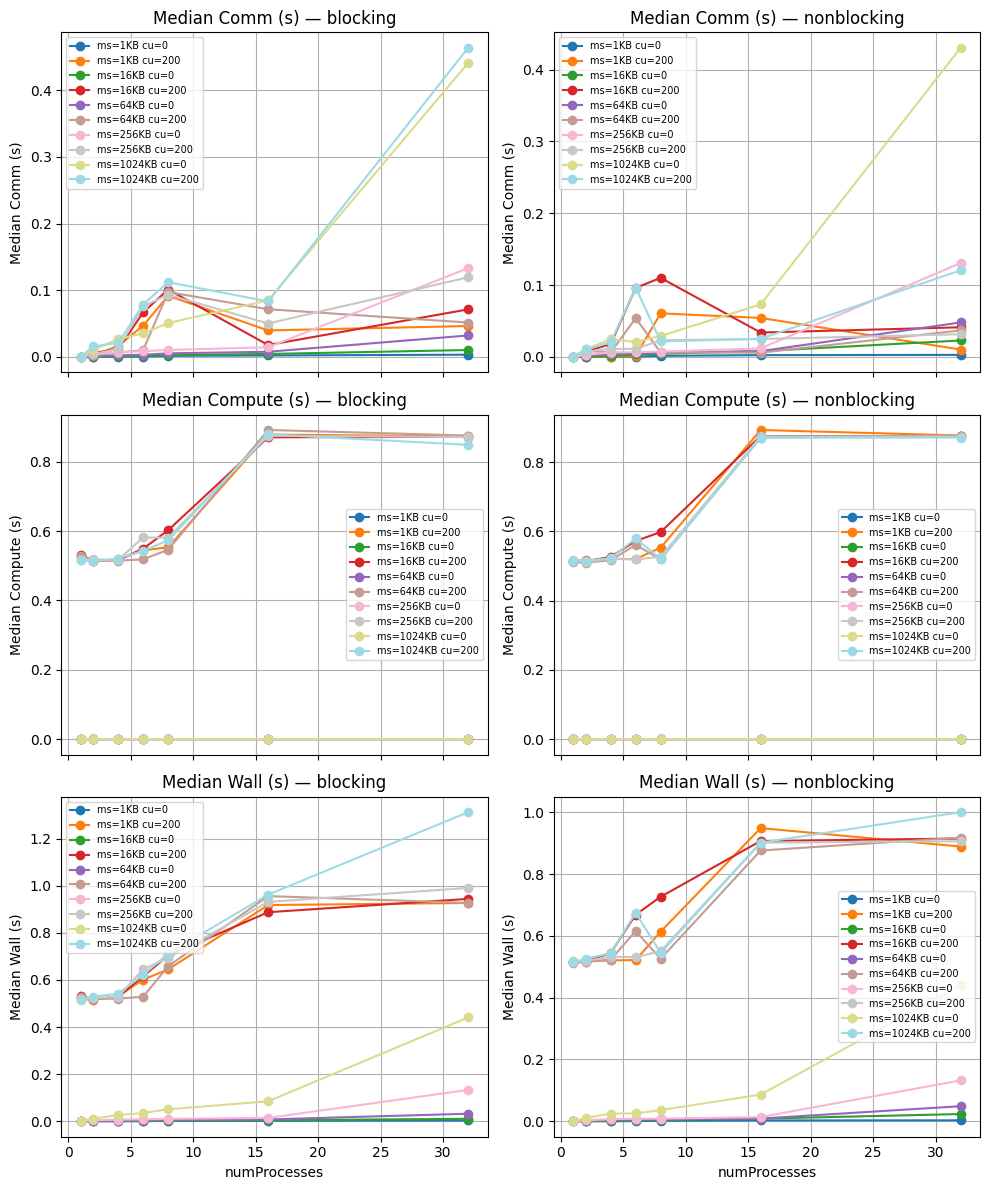

In [13]:
modes = ["blocking","nonblocking"]
metrics = ["medianComm","medianCompute","medianWall"]
metricLabels = {"medianComm":"Median Comm (s)", "medianCompute":"Median Compute (s)", "medianWall":"Median Wall (s)"}

messageSizes = sorted(groupedDf["messageSizeBytes"].unique())
uniquePairsDf = groupedDf[["messageSizeBytes","computeUnits"]].drop_duplicates()
uniquePairs = [tuple(x) for x in uniquePairsDf.values]
numUniqueLines = len(uniquePairs)

if numUniqueLines <= 20:
    colorMapName = "tab20"
    colorMap = plt.get_cmap(colorMapName, numUniqueLines)
    colorsList = [colorMap(i) for i in range(numUniqueLines)]
else:
    colorMapName = "hsv"
    colorMap = plt.get_cmap(colorMapName)
    colorsList = [colorMap(i / numUniqueLines) for i in range(numUniqueLines)]

colorMapping = {pair: colorsList[idx] for idx, pair in enumerate(uniquePairs)}

fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * len(modes), 4 * len(metrics)), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for ms in messageSizes:
            sub = groupedDf[(groupedDf["mode"]==modeVal) & (groupedDf["messageSizeBytes"]==ms)]
            if sub.empty:
                continue
            for cu in sorted(sub["computeUnits"].unique()):
                subLine = sub[sub["computeUnits"]==cu].sort_values("numProcesses")
                if subLine.empty:
                    continue
                x = subLine["numProcesses"].values
                y = subLine[metric].values
                label = f"ms={ms//1024}KB cu={cu}"
                colorForLine = colorMapping.get((ms, cu))
                ax.plot(x, y, marker='o', linestyle='-', label=label, color=colorForLine)
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.legend(fontsize=7)
plt.tight_layout()
plt.show()


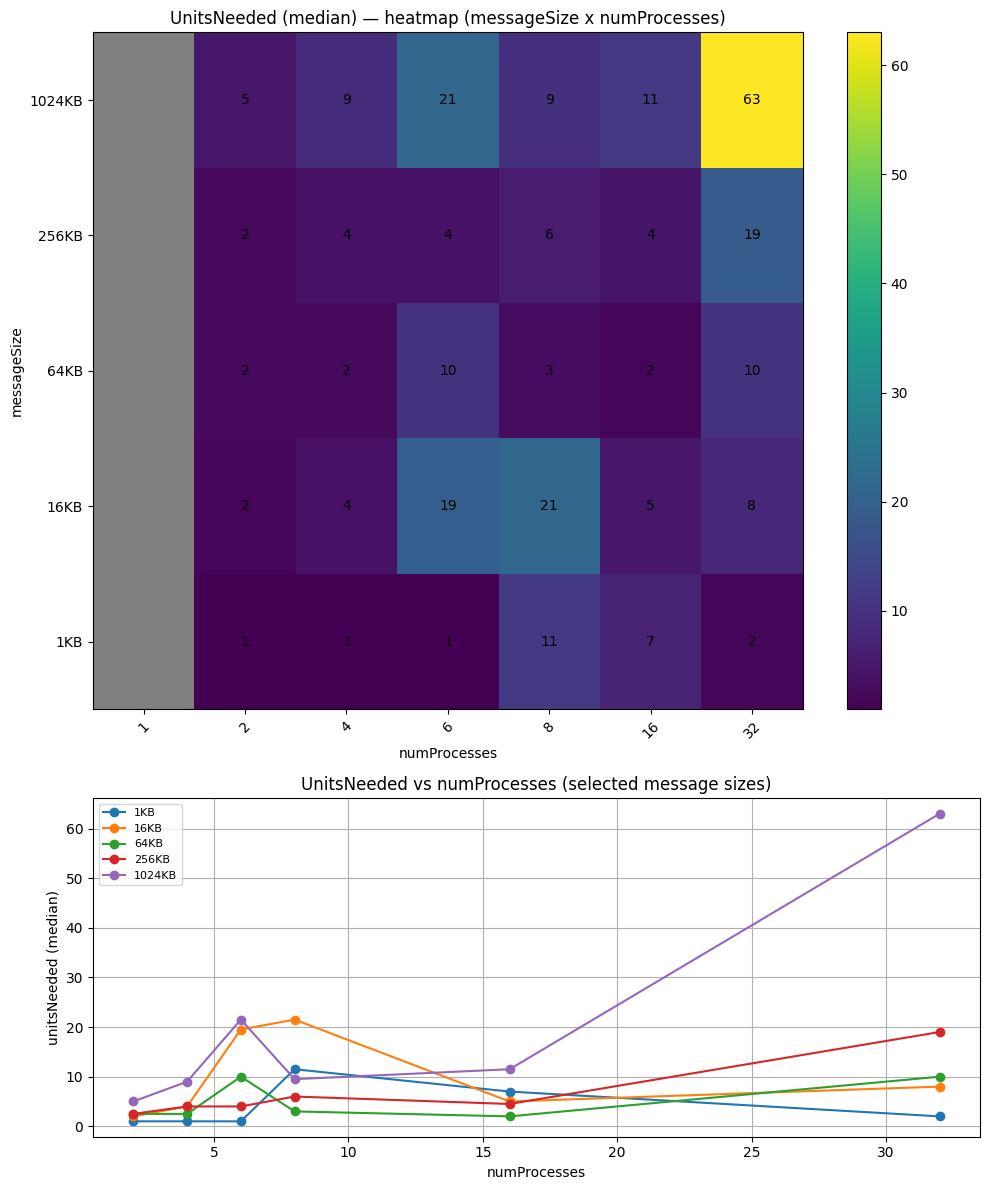

In [23]:
pivotDf = nbDf.pivot_table(index="messageSizeBytes", columns="numProcesses", values="unitsNeeded", aggfunc="median")
pivotDf = pivotDf.sort_index()
pivotValues = pivotDf.values.astype(float)

mask = np.isnan(pivotValues) | (pivotValues == 0)
ma = np.ma.masked_array(pivotValues, mask=mask)

fig, axes = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios':[2,1]})

ax = axes[0]
cmap = plt.get_cmap("viridis").copy()
cmap.set_bad(color="gray")

im = ax.imshow(ma, aspect='auto', origin='lower', cmap=cmap)

ax.set_yticks(range(len(pivotDf.index)))
ax.set_yticklabels([f"{int(x)//1024}KB" if x>=1024 else f"{int(x)}B" for x in pivotDf.index])
ax.set_xticks(range(len(pivotDf.columns)))
ax.set_xticklabels(pivotDf.columns, rotation=45)
ax.set_xlabel("numProcesses")
ax.set_ylabel("messageSize")
ax.set_title("UnitsNeeded (median) — heatmap (messageSize x numProcesses)")

nRows, nCols = ma.shape
fontSize = max(6, int(10 * 12 / max(12, max(nRows, nCols))))
for i in range(nRows):
    for j in range(nCols):
        if ma.mask[i, j]:
            continue
        val = ma[i, j]
        ax.text(j, i, f"{int(val)}", ha='center', va='center', color='black', fontsize=fontSize)

cbar = fig.colorbar(im, ax=ax, orientation='vertical')

ax2 = axes[1]
selectedMessageSizes = sorted(pivotDf.index)
step = max(1, len(selectedMessageSizes)//6)
selectedMessageSizes = selectedMessageSizes[::step]

for ms in selectedMessageSizes:
    y = pivotDf.loc[ms].values
    y_plot = np.where(np.isnan(y) | (y == 0), np.nan, y)
    label = f"{ms//1024}KB" if ms>=1024 else f"{ms}B"
    ax2.plot(pivotDf.columns, y_plot, marker='o', linestyle='-', label=label)

ax2.set_xlabel("numProcesses")
ax2.set_ylabel("unitsNeeded (median)")
ax2.set_title("UnitsNeeded vs numProcesses (selected message sizes)")
ax2.grid(True)
ax2.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()


In [15]:
display(nbDf.sort_values(["messageSizeBytes","numProcesses"]).head(120))


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute,unitsNeeded
210,nonblocking,1024,1,0,0.000007,0.000000,0.000003,3,5.773503e-07,0.002648,0
211,nonblocking,1024,1,200,0.515178,0.000000,0.515173,3,1.112917e-01,0.002648,0
212,nonblocking,1024,2,0,0.000174,0.000054,0.000004,3,7.810250e-06,0.002615,1
213,nonblocking,1024,2,200,0.517049,0.000077,0.516805,3,1.233352e-03,0.002615,1
214,nonblocking,1024,4,0,0.000248,0.000099,0.000004,3,2.421432e-05,0.002576,1
...,...,...,...,...,...,...,...,...,...,...,...
275,nonblocking,1048576,8,200,0.545190,0.021446,0.520883,3,7.311831e-02,0.002883,8
276,nonblocking,1048576,16,0,0.086326,0.073064,0.000007,3,8.846429e-04,0.004420,17
277,nonblocking,1048576,16,200,0.901992,0.025205,0.870578,3,2.449555e-02,0.004420,6
278,nonblocking,1048576,32,0,0.440507,0.430491,0.000005,3,9.901015e-04,0.004406,98
